In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()

# Single experiment, move to ensemble further on
# Some good parameter values are stored as comments right now
# because this is really good practice

using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

  Activating project at `~/covid19/discovering_missing_terms`
┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq /Users/adrocampos/.julia/packages/DataDrivenDiffEq/fivVr/src/DataDrivenDiffEq.jl:168


Plots.GRBackend()

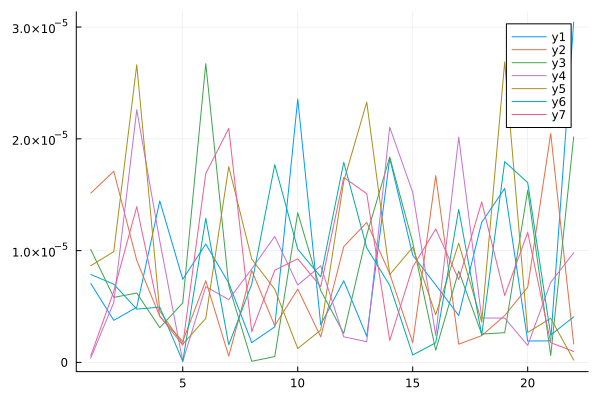

In [2]:
function corona!(du,u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p
    dS = -β0*S*F/N - β(t,β0,D,N,κ,α)*S*I/N -μ*S # susceptible
    dE = β0*S*F/N + β(t,β0,D,N,κ,α)*S*I/N -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases

    du[1] = dS; du[2] = dE; du[3] = dI; du[4] = dR
    du[5] = dN; du[6] = dD; du[7] = dC
end
β(t,β0,D,N,κ,α) = β0*(1-α)*(1-D/N)^κ
S0 = 14e6
u0 = [0.9*S0, 0.0, 0.0, 0.0, S0, 0.0, 0.0]
p_ = [10.0, 0.5944, 0.4239, 1117.3, 0.02, 1/3, 1/5,0.2, 1/11.2]
R0 = p_[2]/p_[7]*p_[6]/(p_[6]+p_[5])
tspan = (0.0, 21.0)
prob = ODEProblem(corona!, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)

tspan2 = (0.0,60.0)
prob = ODEProblem(corona!, u0, tspan2, p_)
solution_extrapolate = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)

# Ideal data
tsdata = Array(solution)
# Add noise to the data
noisy_data = tsdata + Float32(1e-5)*randn(eltype(tsdata), size(tsdata))

plot(abs.(tsdata-noisy_data)')

In [15]:
size(noisy_data)

(7, 22)

In [18]:
println(noisy_data[2,:])

[4.166793433632235e-6, 4.579794465829032, 8.146065744510722, 11.209094500825687, 14.046744101562346, 16.81144556396384, 19.587663642139987, 22.423126973103827, 25.345874086261098, 28.373224505200987, 31.516940438139905, 34.785722069481444, 38.186773225217586, 41.72649708583942, 45.41106514015303, 49.24652986240733, 53.23892880414974, 57.394530283747564, 61.719618704946505, 66.22073535407313, 70.90460292199634, 75.7780749724868]


In [5]:
### Neural ODE

ann_node = FastChain(FastDense(7, 64, tanh),FastDense(64, 64, tanh), FastDense(64, 64, tanh), FastDense(64, 7))
p = Float64.(initial_params(ann_node))

function dudt_node(u,p,t)
    S,E,I,R,N,D,C = u
    F,β0,α,κ,μ,σ,γ,d,λ = p_
    dS,dE,dI,dR,dD = ann_node([S/N,E,I,R,N,D/N,C],p)

    dN = -μ*N # total population
    dC = σ*E # +cumulative cases

    [dS,dE,dI,dR,dN,dD,dC]
end
prob_node = ODEProblem(dudt_node, u0, tspan, p)
s = concrete_solve(prob_node, Tsit5(), u0, p, saveat = solution.t)

function predict(θ)
    Array(concrete_solve(prob_node, Vern7(), u0, θ, saveat = 1,
                         abstol=1e-6, reltol=1e-6))
end

# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, (noisy_data[2:4,:] .- pred[2:4,:])), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

loss(p)

const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end

res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

prob_node2 = ODEProblem(dudt_node, u0, tspan, res2_node.minimizer)
s = solve(prob_node2, Tsit5(), saveat = 1)
scatter(solution, vars=[2,3,4], label=["True Exposed" "True Infected" "True Recovered"])
plot!(s, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])

# Plot the losses
plot(losses, yaxis = :log, xaxis = :log, xlabel = "Iterations", ylabel = "Loss")

# Extrapolate out
prob_node_extrapolate = ODEProblem(dudt_node,u0, tspan2, res2_node.minimizer)
_sol_node = solve(prob_node_extrapolate, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)
p_node = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"], title="Neural ODE Extrapolation")
plot!(p_node,_sol_node, lw=5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_node,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_node[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("neuralode_extrapolation.png")
savefig("neuralode_extrapolation.pdf")

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


7651.549938981307
7650.4863178642645
7650.425173444001
7650.425095565854
7650.425094541437
7650.425094534034
7650.425094534037
7650.425094533916
7650.425094534304
7650.425094534162


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6
┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


"/Users/adrocampos/covid19/discovering_missing_terms/neuralode_extrapolation.pdf"

In [5]:
p_

9-element Vector{Float64}:
   10.0
    0.5944
    0.4239
 1117.3
    0.02
    0.3333333333333333
    0.2
    0.2
    0.08928571428571429

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9
┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


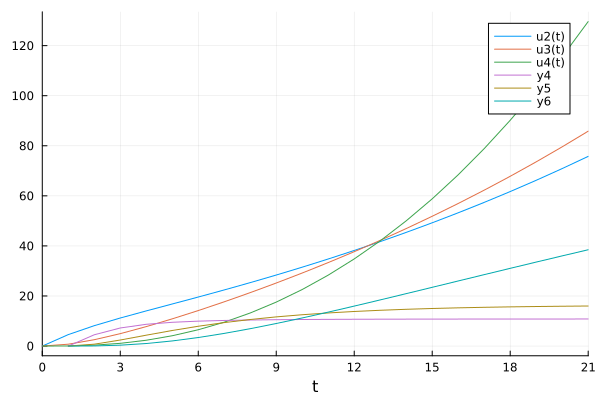

In [3]:
### Universal ODE Part 1

ann = FastChain(FastDense(3, 64, tanh),FastDense(64, 64, tanh), FastDense(64, 1))
p = Float64.(initial_params(ann))

function dudt_(u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p_
    z = ann([S/N,I,D/N],p) # Exposure does not depend on exposed, removed, or cumulative!
    dS = -β0*S*F/N - z[1] -μ*S # susceptible
    dE = β0*S*F/N + z[1] -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases
    [dS,dE,dI,dR,dN,dD,dC]
end
prob_nn = ODEProblem(dudt_,u0, tspan, p)
s = concrete_solve(prob_nn, Tsit5(), u0, p, saveat = 1)


plot(solution, vars=[2,3,4])
plot!(s[2:4,:]')

In [4]:
s

retcode: Success
Interpolation: 1st order linear
t: 22-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
 14.0
 15.0
 16.0
 17.0
 18.0
 19.0
 20.0
 21.0
u: 22-element Vector{Vector{Float64}}:
 [1.26e7, 0.0, 0.0, 0.0, 1.4e7, 0.0, 0.0]
 [1.2350497970293144e7, 4.512457542688175, 0.7485842276849592, 0.052330187969554146, 1.3722781426294552e7, 0.010282254915609083, 0.80644455067023]
 [1.2105936942722792e7, 7.224197382210273, 2.410561189938761, 0.35583768287387046, 1.3451052148132268e7, 0.0686271138149366, 2.806167317516963]
 [1.186621906288499e7, 8.695669639734016, 4.347111474132703, 1.0174955470870652, 1.3184703470179606e7, 0.1924219351193761, 5.484960230269598]
 [1.1631248197468959e7, 9.493904552351594, 6.225869360835381, 2.0472287961001454, 1.292362884941296e7, 0.37929200106704986, 8.52948490046453]
 [1.1400930190849502e7, 9.951601047339029, 7.9139902707453675, 3.4108147482883204, 1.2667723852506181e7, 0.6186157927166803, 11.7770

In [12]:
function predict(θ)
    Array(concrete_solve(prob_nn, Vern7(), u0, θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6))
end

# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, noisy_data[2:4,:] .- pred[2:4,:]), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

loss(p)


(66365.48650749485, [1.26e7 1.235049819735119e7 … 8.44595696996365e6 8.278711358813772e6; 0.0 4.326478005463887 … 12.732394262881263 12.735686809754027; … ; 0.0 0.009715720883507986 … 5.698056541022186 5.932333168923131; 0.0 0.7650605602542568 … 74.8289148273006 79.07361818358038])

In [13]:
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end

res1_uode = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


3749.752566122622
1923.8818653618891
2385.9959228824064
304.52359630596754
181.78009875428467
80.13412375650543
117.33385111347597
45.162911337221374
59.29115895496824
35.98493543475695


u: 4481-element Vector{Float64}:
  0.13409993951227878
  0.2487421133592284
 -0.28589211566572575
 -0.041559374112253814
 -0.25428065186464305
  0.16271737330904154
 -0.1182847460090016
  0.03428109123828738
  0.3175978965790845
  0.046843414756774504
  0.04962956817788194
  0.08773238414922908
 -0.19569042650531712
  ⋮
  0.3714907810916594
 -0.3442076262464923
 -0.5323662420419332
  0.29572489400932395
  0.2864008217946068
 -0.37432025800028235
 -0.4450847048983035
  0.41511963308698385
 -0.08496038009485869
 -0.41271359127420343
 -0.4702855551518426
  0.2005429458495652

In [6]:

res2_uode = DiffEqFlux.sciml_train(loss, res1_uode.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

loss(res2_uode.minimizer)

prob_nn2 = ODEProblem(dudt_,u0, tspan, res2_uode.minimizer)
uode_sol = solve(prob_nn2, Tsit5(), saveat = 1)
plot(solution, vars=[2,3,4])
plot!(uode_sol, vars=[2,3,4])

# Plot the losses
plot(losses, yaxis = :log, xaxis = :log, xlabel = "Iterations", ylabel = "Loss")

# Collect the state trajectory and the derivatives
X = noisy_data
# Ideal derivatives
DX = Array(solution(solution.t, Val{1}))

# Extrapolate out
prob_nn2 = ODEProblem(dudt_,u0, tspan2, res2_uode.minimizer)
_sol_uode = solve(prob_nn2, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 1)
p_uode = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"], title="Universal ODE Extrapolation")
plot!(p_uode,_sol_uode, lw = 5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_uode,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_uode[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("universalode_extrapolation.png")
savefig("universalode_extrapolation.pdf")


┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9


LoadError: UndefVarError: ReverseDiffVJP not defined

In [ ]:

### Universal ODE Part 2: SInDy to Equations

# Create a Basis
@variables u[1:3]
# Lots of polynomials
polys = Operation[]
for i ∈ 0:2, j ∈ 0:2, k ∈ 0:2
    push!(polys, u[1]^i * u[2]^j * u[3]^k)
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; unique(polys)...]
basis = Basis(h, u)

X = noisy_data
# Ideal derivatives
DX = Array(solution(solution.t, Val{1}))
S,E,I,R,N,D,C = eachrow(X)
F,β0,α,κ,μ,_,γ,d,λ = p_
L = β.(0:tspan[end],β0,D,N,κ,α).*S.*I./N
L̂ = vec(ann([S./N I D./N]',res2_uode.minimizer))
X̂ = [S./N I D./N]'

scatter(L,title="Estimated vs Expected Exposure Term",label="True Exposure")
plot!(L̂,label="Estimated Exposure")
savefig("estimated_exposure.png")
savefig("estimated_exposure.pdf")

# Create an optimizer for the SINDY problem
opt = SR3()
# Create the thresholds which should be used in the search process
thresholds = exp10.(-6:0.1:1)

# Test on original data and without further knowledge
Ψ_direct = SInDy(X[2:4, :], DX[2:4, :], basis, thresholds, opt = opt, maxiter = 50000) # Fail
println(Ψ_direct.basis)
# Test on ideal derivative data ( not available )
Ψ_ideal = SInDy(X[2:4, 5:end], L[5:end], basis, thresholds, opt = opt, maxiter = 50000) # Succeed
println(Ψ_ideal.basis)
# Test on uode derivative data
Ψ = SInDy(X̂[:, 2:end], L̂[2:end], basis, thresholds,  opt = opt, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ.basis)

# Build a ODE for the estimated system
function approx(u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p_
    z = Ψ([S/N,I,D/N]) # Exposure does not depend on exposed, removed, or cumulative!
    dS = -β0*S*F/N - z[1] -μ*S # susceptible
    dE = β0*S*F/N + z[1] -(σ+μ)*E # exposed
    dI = σ*E - (γ+μ)*I # infected
    dR = γ*I - μ*R # removed (recovered + dead)
    dN = -μ*N # total population
    dD = d*γ*I - λ*D # severe, critical cases, and deaths
    dC = σ*E # +cumulative cases

    [dS,dE,dI,dR,dN,dD,dC]
end

# Create the approximated problem and solution
a_prob = ODEProblem{false}(approx, u0, tspan2, p_)
a_solution = solve(a_prob, Tsit5())

p_uodesindy = scatter(solution_extrapolate, vars=[2,3,4], legend = :topleft, label=["True Exposed" "True Infected" "True Recovered"])
plot!(p_uodesindy,a_solution, lw = 5, vars=[2,3,4], label=["Estimated Exposed" "Estimated Infected" "Estimated Recovered"])
plot!(p_uodesindy,[20.99,21.01],[0.0,maximum(hcat(Array(solution_extrapolate[2:4,:]),Array(_sol_uode[2:4,:])))],lw=5,color=:black,label="Training Data End")

savefig("universalodesindy_extrapolation.png")
savefig("universalodesindy_extrapolation.pdf")